In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='NanumGothic')
sns.set(font="Malgun Gothic")

In [91]:
def detect_outliers(df,columns):
    q1=df[columns].quantile(0.25)
    q3=df[columns].quantile(0.75)
    iqr=q3-q1
    
    boundary=1.5*iqr
    
    index1=df[df[columns] > q3+boundary].index
    index2=df[df[columns] < q1-boundary].index 
    
#     df.loc[:,columns]=df[columns].drop(index1)
#     df.loc[:,columns]=df[columns].drop(index2)

    df = df.drop(index1)
    df = df.drop(index2)
    
    return df

def detect_outliers_per_group(df, group_column, value_column):
    group_values = set(df[group_column])
    df_list = []
    for group_value in group_values:
        sub_df = df[df[group_column] == group_value]
        
        sub_df = detect_outliers(sub_df, value_column)
#         sub_df[value_column] = sub_df[value_column]
        sub_df = sub_df.dropna()
        df_list.append(sub_df)
    return pd.concat(df_list)

In [92]:
ORIGIN_DATA_DIR = "data/origin_deathmatch"

RESULT_DATA_DIR = "data/extracted_deathmatch"
RESULT_FILE_NAME = "log.csv"

In [93]:
def extract_log():
    
    file_list = os.listdir(ORIGIN_DATA_DIR)
    df_list = []
    for i, file_name in enumerate(file_list):
        # player log data load 및 전처리
        path = os.path.join(ORIGIN_DATA_DIR, file_name)
        df = pd.read_csv(path, encoding = "cp949")
        df["id"] = df["id"]+i*10
        df_list.append(df)
        
    # 모두 합치기
    df = pd.concat(df_list)
    
    # 전처리
    df["death"] = df["dead"]
    del df["dead"]
    
    
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df["time"] = df["end_time"] - df["start_time"]
    
    del df['start_time']
    del df['end_time']
    
#     second = df['time'].apply(lambda x : x.seconds)
#     minute = df['time'].apply(lambda x : x.minutes)
    df["time"] = df["time"].apply(lambda x : str(x))
    second = df['time'].apply(lambda x : int(x.split(":")[2][:2]))
    minute = df['time'].apply(lambda x : int(x.split(":")[1]))
    df["time"] = second+minute*60
    
    df.replace("aimer", "Artisan", inplace = True)
    df.replace("runner", "Explorer", inplace = True)
    df.replace("aggressive", "Manager", inplace = True)
    df.replace("defensive", "Conqueror", inplace = True)
    df.replace("hider", "Guardian", inplace = True)
    
    # save
    if not os.path.exists(RESULT_DATA_DIR):
        os.makedirs(RESULT_DATA_DIR)
        
    path = os.path.join(RESULT_DATA_DIR, RESULT_FILE_NAME)
    df.to_csv(path, index=False, encoding = "cp949")

extract_log()

In [94]:
def get_df():
    path = os.path.join(RESULT_DATA_DIR, RESULT_FILE_NAME)
    return pd.read_csv(path, encoding = "cp949")
get_df()

,id,name,episode,agent,kill,death,time
0,0,enemy,0,Conqueror,35.0,0,60
1,0,enemy,1,Manager,40.0,0,60
2,0,enemy,2,Artisan,17.0,1,36
3,0,enemy,3,Guardian,0.0,0,60
4,0,enemy,4,Explorer,5.0,1,18
...,...,...,...,...,...,...,...
995,99,enemy,5,Conqueror,41.0,0,60
996,99,enemy,6,Manager,50.0,0,60
997,99,enemy,7,Artisan,17.0,1,24
998,99,enemy,8,Guardian,5.0,1,23


In [95]:
df = get_df()
df.groupby("agent").mean()

,id,episode,kill,death,time
agent,,,,,
Artisan,49.5,4.5,13.06,0.995,26.325
Conqueror,49.5,2.5,38.95,0.170,54.285
Explorer,49.5,6.5,6.50,0.990,19.730
Guardian,49.5,5.5,5.03,0.665,34.895
Manager,49.5,3.5,30.32,0.460,45.660


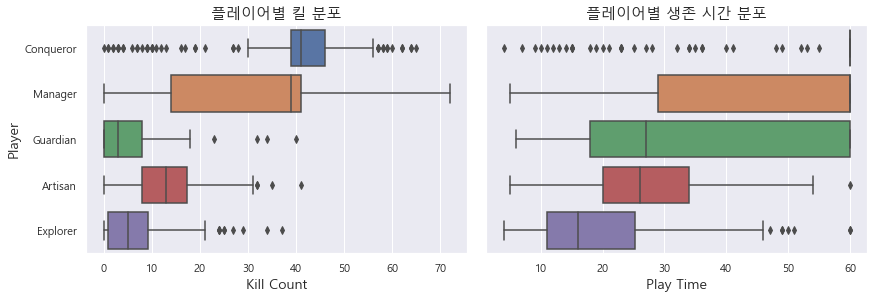

In [111]:
sns.set(font="Malgun Gothic")

plt.figure(figsize=(14, 4.2))
plt.subplots_adjust(wspace = 0.05)

########################################################################
plt.subplot(121)
# agent-kill
df = get_df()
df = df[["agent", "kill"]]

# 이상치 제거
# df = detect_outliers_per_group(df, "agent", "kill")

sns.boxplot(data=df, y = "agent", x="kill", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer"])
plt.title("플레이어별 킬 분포", fontsize=15)
plt.xlabel("Kill Count", fontsize = 14)
plt.ylabel("Player", fontsize = 14)

########################################################################
plt.subplot(122)
# agent-death
df = get_df()

# 이상치 제거
# df = detect_outliers_per_group(df, "agent", "death")

p = sns.boxplot(data=df, y = "agent", x="time", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer"])
plt.title("플레이어별 생존 시간 분포", fontsize=15)
plt.xlabel("Play Time", fontsize = 14)
plt.ylabel("Player", fontsize = 14)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기

# plt.tight_layout()
plt.savefig("NPC별 킬 데스 분포.svg")